In [2]:
import pandas as pd
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import random
import matplotlib.animation as animation


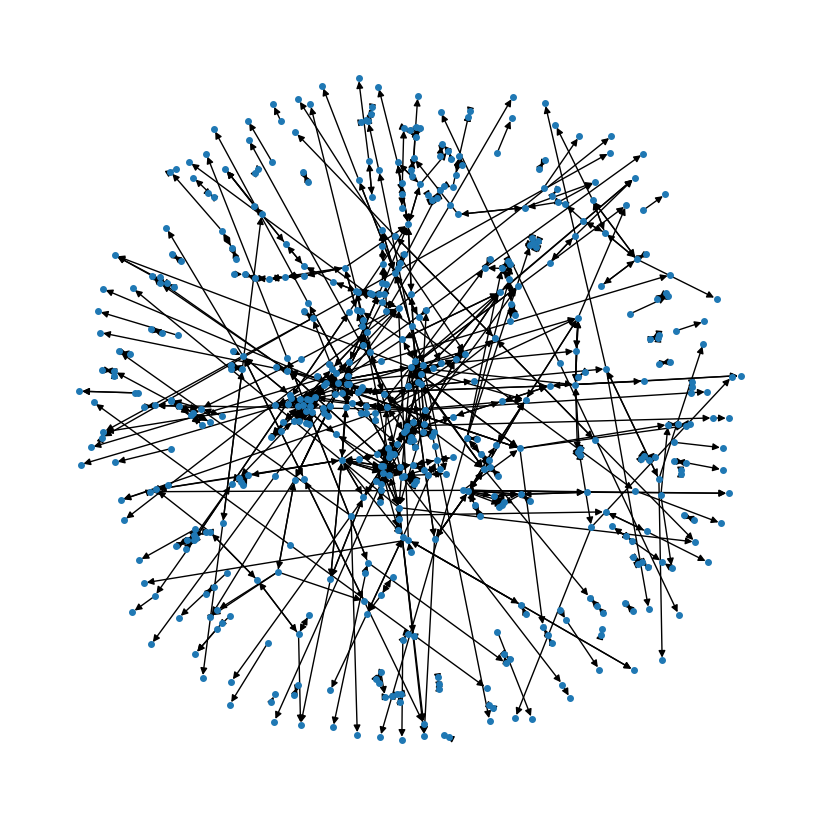

In [3]:
G = pd.read_csv('calls.csv')
G = nx.from_pandas_edgelist(G, 'caller', 'callee', ['duration', 'timestamp'], create_using=nx.DiGraph())
G.remove_edges_from(nx.selfloop_edges(G))
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)
threshold = 0.5
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d.get("weight", 1) < threshold]
G.remove_edges_from(edges_to_remove)
plt.figure(figsize=(8, 8))
nx.draw(G, node_size=16)
plt.show()

In [4]:
degrees = [d for _, d in G.degree()]
degree_counts = Counter(degrees)
k, freq = zip(*degree_counts.items())
total_nodes = G.number_of_nodes()
pk = [f / total_nodes for f in freq]

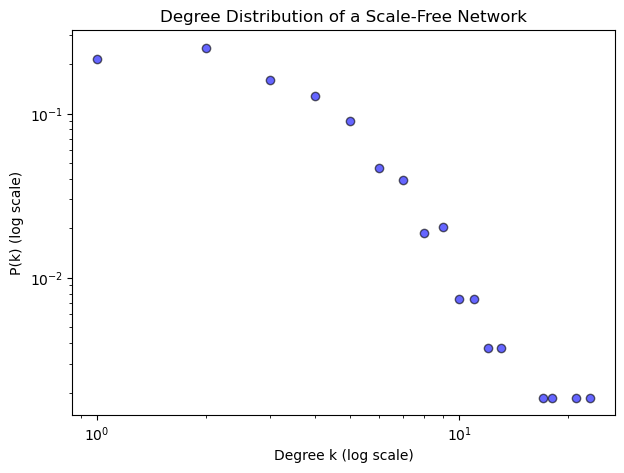

In [5]:
plt.figure(figsize=(7,5))
plt.scatter(k, pk, color="blue", alpha=0.6, edgecolors="k")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree k (log scale)")
plt.ylabel("P(k) (log scale)")
plt.title("Degree Distribution of a Scale-Free Network")
plt.show()


In [6]:
log_k = np.log(np.array(k))
log_pk = np.log(np.array(pk))
slope, intercept = np.polyfit(log_k, log_pk, 1)
gamma = -slope

print(f"Estimated power-law exponent γ ≈ {gamma:.2f}")

Estimated power-law exponent γ ≈ 1.99


In [7]:
fit = powerlaw.Fit(degrees, discrete=True)
print(f"Estimated alpha (exponent): {fit.alpha:.2f}")
print(f"Estimated xmin (cutoff): {fit.xmin}")

Calculating best minimal value for power law fit
Estimated alpha (exponent): 4.21
Estimated xmin (cutoff): 7.0


In [8]:
print(f"KS statistic: {fit.D:.4f}")

KS statistic: 0.0405


In [9]:
R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Loglikelihood ratio (R): {R:.2f}, p-value: {p:.4f}")

Loglikelihood ratio (R): -0.17, p-value: 0.6790


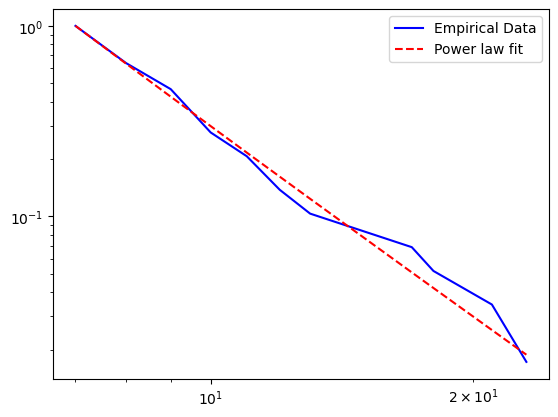

In [10]:
fig = fit.plot_ccdf(color='b', label='Empirical Data')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
plt.legend()
plt.show()

In [11]:
def get_largest_component(G):
    """
    Returns the largest connected component subgraph.
    Works for both directed and undirected graphs.
    """
    if G.is_directed():
        # Use weakly connected components for spread (ignores direction)
        largest_cc = max(nx.weakly_connected_components(G), key=len)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
    return G.subgraph(largest_cc).copy()

def simulate_hoax(G, beta=0.3, gamma=0.05, steps=50):
    """
    Simulates hoax spread on graph G using an SIR-like model.
    beta = infection probability
    gamma = recovery probability
    steps = number of iterations
    """
    # Extract largest component
    G_lcc = get_largest_component(G)

    # Initialize states: 0=S, 1=I, 2=R
    state = {n: 0 for n in G_lcc.nodes()}

    # Infect a hub (highest degree node)
    hub = max(G_lcc.degree, key=lambda x: x[1])[0]
    state[hub] = 1

    # Track counts
    S, I, R = [], [], []

    for t in range(steps):
        new_state = state.copy()
        for node in G_lcc.nodes():
            if state[node] == 1:  # infected
                # Try to infect neighbors
                for neigh in G_lcc.neighbors(node):
                    if state[neigh] == 0 and random.random() < beta:
                        new_state[neigh] = 1
                # Recovery
                if random.random() < gamma:
                    new_state[node] = 2
        state = new_state

        # Count states
        S.append(sum(1 for v in state.values() if v == 0))
        I.append(sum(1 for v in state.values() if v == 1))
        R.append(sum(1 for v in state.values() if v == 2))

    return S, I, R



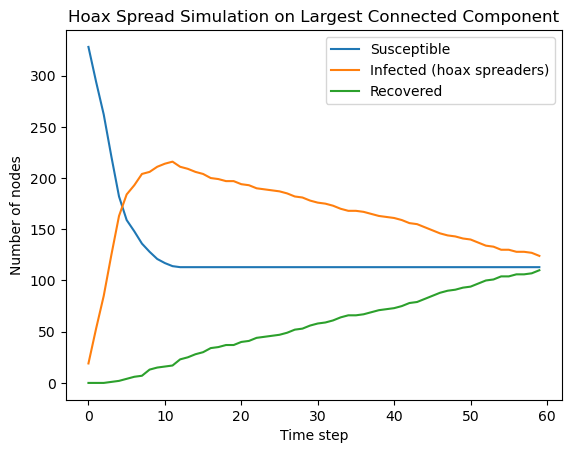

In [35]:
S, I, R = simulate_hoax(G, beta=1, gamma=0.01, steps=60)

plt.plot(S, label="Susceptible")
plt.plot(I, label="Infected (hoax spreaders)")
plt.plot(R, label="Recovered")
plt.xlabel("Time step")
plt.ylabel("Number of nodes")
plt.legend()
plt.title("Hoax Spread Simulation on Largest Connected Component")
plt.show()
